In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hmmlearn.hmm as hmm
from math import floor
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,roc_curve
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import os
import glob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from pathlib import Path
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense

In [164]:
def get_all_raw_data(file_prefix='pipeline/data_files/raw_mags_1m', file_extension="raw_mags_1m.py"):
    # Define the file prefix and extension 
    file_extension = 'csv'

    # Create the search pattern using a wildcard '*'
    # e.g., 'your_prefix_*.csv'
    pattern = f"{file_prefix}*.{file_extension}" 

    # Get a list of all files matching the pattern
    # You can specify a full directory path if needed, e.g., 'path/to/files/{pattern}'
    file_list = glob.glob(pattern)

    # Initialize an empty list to store individual DataFrames
    dfs = []

    # Loop through the files, read each into a DataFrame, and append to the list
    for filename in file_list:
        df = pd.read_csv(filename)
        dfs.append(df)

    # Concatenate all DataFrames in the list
    # ignore_index=True ensures a continuous index in the final DataFrame, discarding original indices
    combined_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined DataFrame
    #print(combined_df.head())
    return combined_df

In [168]:
features=pd.read_csv("pipeline/data_files/features_combined.csv")
features['Datetime']=pd.to_datetime(features['Datetime'])

C:\Users\masol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\masol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\masol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='hist_vol'>

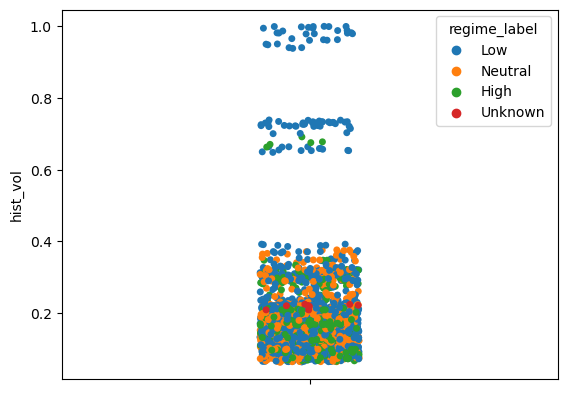

In [169]:
sns.stripplot(data=features,y='hist_vol',hue='regime_label')

In [170]:
ohclv=get_all_raw_data()
ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)

In [171]:
ohclv.Datetime

0      2025-10-29 08:30:00
1      2025-10-29 08:31:00
2      2025-10-29 08:32:00
3      2025-10-29 08:33:00
4      2025-10-29 08:34:00
               ...        
3107   2025-11-07 15:55:00
3108   2025-11-07 15:56:00
3109   2025-11-07 15:57:00
3110   2025-11-07 15:58:00
3111   2025-11-07 15:59:00
Name: Datetime, Length: 3112, dtype: datetime64[ns]

In [172]:
df=ohclv.merge(features,on='Datetime',how='inner')

,Datetime,open,high,low,close,volume,news_cnt_5m,news_cnt_15m,news_cnt_60m,sent_sum_pos_5m,...,sent_sum_neg_15m,sent_net_15m,sent_sum_pos_60m,sent_sum_neg_60m,sent_net_60m,sent_ewm_60m,pred_vol,hist_vol,vol_ratio,regime_label
0,2025-11-03 09:30:00,68.760002,68.769997,68.629997,68.709999,226636,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.331227,0.726487,0.455930,Low
1,2025-11-03 09:31:00,68.709999,68.809998,68.709999,68.779999,32665,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.831485,0.727115,5.269434,Low
2,2025-11-03 09:32:00,68.760002,68.820000,68.745003,68.795601,18695,1.0,1.0,1.0,0.046543,...,0.018217,0.001888,0.046543,0.018217,0.000472,0.000325,0.577966,0.726885,0.795127,Low
3,2025-11-03 09:33:00,68.809998,68.879997,68.809998,68.875000,26930,1.0,1.0,1.0,0.046543,...,0.018217,0.001888,0.046543,0.018217,0.000472,0.000322,0.504268,0.728228,0.692458,Low
4,2025-11-03 09:34:00,68.870003,68.879997,68.799896,68.830002,32571,3.0,3.0,3.0,1.005269,...,0.292655,0.024698,1.005269,0.292655,0.006175,0.004248,0.599995,0.730433,0.821424,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,2025-11-07 15:55:00,65.489998,65.595001,65.470001,65.580002,37146,0.0,0.0,4.0,0.000000,...,0.000000,0.000000,1.854633,1.906158,-0.000859,-0.016440,0.621165,0.224823,2.762908,Unknown
1938,2025-11-07 15:56:00,65.589996,65.605003,65.565002,65.584999,39270,0.0,0.0,4.0,0.000000,...,0.000000,0.000000,1.854633,1.906158,-0.000859,-0.016252,0.621897,0.224306,2.772537,Unknown
1939,2025-11-07 15:57:00,65.589996,65.620003,65.574997,65.619301,31935,0.0,0.0,4.0,0.000000,...,0.000000,0.000000,1.854633,1.906158,-0.000859,-0.016065,0.490334,0.220623,2.222503,Unknown
1940,2025-11-07 15:58:00,65.614998,65.669998,65.614998,65.669998,65847,0.0,0.0,4.0,0.000000,...,0.000000,0.000000,1.854633,1.906158,-0.000859,-0.015880,0.516493,0.221256,2.334366,Unknown


In [176]:
def create_train_test_data(feature_set_name='pipeline/data_files/features_combined.csv'
                           ,ohclv_name='pipeline/data_files/raw_mags_1m.csv'
                           ,alternative_data=False):
    df=pd.read_csv(feature_set_name)
    df['Datetime']=pd.to_datetime(df['Datetime'])
    ohclv=pd.read_csv(ohclv_name)
    ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
    ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)
    features=ohclv.merge(df,on='Datetime',how='inner')
    ids=features['Datetime']
    if alternative_data:
        X=features.drop(['Datetime','regime_label','pred_vol','hist_vol','vol_ratio'],axis=1)[features.regime_label!='Unknown']
    else:
        X=features[['open','high','low','close','close','volume']][features.regime_label!='Unknown']
    y=features['regime_label'].replace({'Unknown':3,
                                       'Low':0,
                                       'Neutral':1,
                                       'High':2})[features.regime_label!='Unknown']
    train_x,test_x=X[:floor(len(features)*0.7)],X[floor(len(features)*0.7):]
    train_y,test_y=y[:floor(len(features)*0.7)],y[floor(len(features)*0.7):]
    
    return train_x,test_x,train_y,test_y
    

In [177]:
train_x,test_x,train_y,test_y=create_train_test_data(alternative_data=False)

C:\Users\masol\AppData\Local\Temp\ipykernel_36096\2692924961.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,


In [178]:
def model_initialization(train_x=train_x,train_y=train_y):
    # Number of hidden states (regimes)
    n_components = len(np.unique(train_y))
    n_features = train_x.shape[1]

    # Manually compute the parameters
    startprob = np.zeros(n_components)
    transmat = np.zeros((n_components, n_components))
    means = np.zeros((n_components, n_features))
    covars = np.zeros((n_components, n_features, n_features))
    
    # Loop through each regime to calculate emission parameters (mean and covariance)
    for i in range(n_components):
        regime_data = train_x[train_y == i]
        means[i] = regime_data.mean(axis=0)
        covars[i] = np.cov(regime_data, rowvar=False) + 1e-6 * np.eye(n_features) # Add epsilon for stability
    
    # Calculate transition probabilities from the labeled sequence
    for i in range(len(train_y) - 1):
        transmat[train_y[i], train_y[i+1]] += 1
        
    # Normalize transition matrix
    transmat = transmat / transmat.sum(axis=1, keepdims=True)
    
    # Calculate initial state probabilities (assuming first data point is labeled correctly)
    startprob[train_y[0]] = 1.0

    # Ensure no zero probabilities
    transmat[transmat == 0] = 1e-9
    transmat = transmat / transmat.sum(axis=1, keepdims=True)
    
    # Create a Gaussian HMM model and initialize with computed parameters
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", init_params="")
    model.startprob_ = startprob
    model.transmat_ = transmat
    model.means_ = means
    model.covars_ = covars

    print("HMM model initialized successfully with supervised parameters.")
    print("Start probabilities:", model.startprob_)
    print("Transition matrix:", model.transmat_)
    print("Means (Emission parameters):", model.means_)


    return model

In [179]:
def forecasting_intialization(X=train_x,y=train_y):
    X=X.values
    lengths = [len(X)] # For a single time series

    # Initialize a GaussianHMM with the correct number of regimes (hidden states)
    n_regimes = y.nunique()
    model = hmm.GaussianHMM(n_components=n_regimes, n_iter=100)
    regimes=y

    # Manually set the known state sequence to guide training
    # hmmlearn does not have a built-in supervised training method, so we use
    # an iterative approach to find the most likely parameters for the given state sequence.
    # This is an alternative to standard EM for when labels are known.

    # Function to re-estimate parameters based on labeled data
    def fit_supervised_hmm(model, X, regimes):
        for i in range(model.n_iter):
            # E-step with known states
            # The E-step is skipped in favor of a known state sequence

            # M-step: Re-estimate parameters (startprob, transmat, means, covars)
            # We manually re-calculate the necessary statistics based on the known labels

            # Re-estimate start probabilities
            model.startprob_ = np.bincount(regimes[:1], minlength=model.n_components) / len(regimes[:1])

            # Re-estimate transition matrix
            for i in range(model.n_components):
                for j in range(model.n_components):
                    # Count transitions from state i to j
                    transitions = np.sum( (regimes[:-1] == i) & (regimes[1:] == j) )
                    total_transitions = np.sum(regimes[:-1] == i)
                    model.transmat_[i, j] = transitions / total_transitions if total_transitions > 0 else 0

            # Re-estimate means and covariances
            for i in range(model.n_components):
                # Isolate data for the current regime
                regime_data = X[regimes == i]
                if len(regime_data) > 0:
                    model.means_[i, :] = np.mean(regime_data, axis=0)
                    model.covars_[i, :, :] = np.cov(regime_data, rowvar=False) + 1e-6 * np.eye(X.shape[1]) # Add small value for numerical stability

        return model

    # Fit the supervised HMM model
    # Note: For real applications, a custom implementation or a different library might be more robust
    # For demonstration, the manual approach is shown.
    supervised_model = fit_supervised_hmm(model, X, y.values)

    # Evaluate the model (optional, but recommended)
    print("Fitted Model Parameters:")
    print("Start probabilities:\n", supervised_model.startprob_)
    print("Transition matrix:\n", supervised_model.transmat_)
    print("Regime Means:\n", supervised_model.means_)
    print("Regime Covariances:\n", supervised_model.covars_)


    return model

In [180]:
#"hmm_forecaster=forecasting_intialization(X=train_x,y=train_y)

In [181]:
hmm_model =model_initialization()

HMM model initialized successfully with supervised parameters.
Start probabilities: [1. 0. 0.]
Transition matrix: [[0.94015957 0.04255319 0.01728723]
 [0.07       0.8875     0.0425    ]
 [0.08252427 0.0631068  0.85436893]]
Means (Emission parameters): [[   67.94459645    67.96258618    67.92672183    67.94468731
     67.94468731  8444.92828685]
 [   67.64889618    67.66732973    67.6311289     67.64984859
     67.64984859  7566.2275    ]
 [   67.39714954    67.41814315    67.36911       67.39008165
     67.39008165 13273.07281553]]


In [182]:
# Use the trained HMM to predict the hidden state sequence
# `model.decode()` returns the log-likelihood and the optimal state sequence
log_prob, predicted_regimes = hmm_model.decode(test_x, algorithm="viterbi")
probs=hmm_model.predict_proba(test_x)

print("\nPredicted regime sequence for new data:")
print(predicted_regimes)


Predicted regime sequence for new data:
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [183]:
accuracy_score(test_y,predicted_regimes)
roc_auc_score(test_y,probs,multi_class='ovr')

0.5593896737018985

# Random Forest

In [186]:
def create_lag_train_test_data(feature_set_name='pipeline/data_files/features_combined.csv'
                           ,ohclv_name='pipeline/data_files/raw_mags_1m.csv'
                           ,alternative_data=False):
    df=pd.read_csv(feature_set_name)
    df['Datetime']=pd.to_datetime(df['Datetime'])
    ohclv=pd.read_csv(ohclv_name)
    ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
    ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)
    features=ohclv.merge(df,on='Datetime',how='inner')
    ids=features['Datetime']
    if alternative_data:
        X=features.drop(['Datetime','regime_label','pred_vol','hist_vol','vol_ratio'],axis=1)[features.regime_label!='Unknown']
    else:
        X=features[['open','high','low','close','close','volume']][features.regime_label!='Unknown']
    X=X.shift(10)
    
    scaler=StandardScaler()
    y=features['regime_label'].replace({'Unknown':3,
                                       'Low':0,
                                       'Neutral':1,
                                       'High':2})[features.regime_label!='Unknown']
    X['target_lag']=y.shift(1)
    train_x,test_x=X[:floor(len(features)*0.7)],X[floor(len(features)*0.7):]
    train_y,test_y=y[:floor(len(features)*0.7)],y[floor(len(features)*0.7):]
    #train_x_scaled=pd.DataFrame(scaler.fit_transform(train_x),columns=X.columns)
    #test_x_scaled=pd.DataFrame(scaler.transform(test_x),columns=X.columns)
    
    return train_x[10:],test_x[10:],train_y[10:],test_y[10:]

In [187]:
train_x_lag,test_x_lag,train_y_lag,test_y_lag=create_lag_train_test_data(alternative_data=True)
train_x_lag_alt,test_x_lag_alt,train_y_lag_alt,test_y_lag_alt=create_lag_train_test_data(alternative_data=True)

C:\Users\masol\AppData\Local\Temp\ipykernel_36096\1319488684.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,
C:\Users\masol\AppData\Local\Temp\ipykernel_36096\1319488684.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,


In [188]:
train_x_lag

,open,high,low,close,volume,news_cnt_5m,news_cnt_15m,news_cnt_60m,sent_sum_pos_5m,sent_sum_neg_5m,sent_net_5m,sent_sum_pos_15m,sent_sum_neg_15m,sent_net_15m,sent_sum_pos_60m,sent_sum_neg_60m,sent_net_60m,sent_ewm_60m,target_lag
10,68.760002,68.769997,68.629997,68.709999,226636.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
11,68.709999,68.809998,68.709999,68.779999,32665.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
12,68.760002,68.820000,68.745003,68.795601,18695.0,1.0,1.0,1.0,0.046543,0.018217,0.005665,0.046543,0.018217,0.001888,0.046543,0.018217,0.000472,0.000325,0.0
13,68.809998,68.879997,68.809998,68.875000,26930.0,1.0,1.0,1.0,0.046543,0.018217,0.005665,0.046543,0.018217,0.001888,0.046543,0.018217,0.000472,0.000322,0.0
14,68.870003,68.879997,68.799896,68.830002,32571.0,3.0,3.0,3.0,1.005269,0.292655,0.074094,1.005269,0.292655,0.024698,1.005269,0.292655,0.006175,0.004248,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,66.153503,66.239998,66.153503,66.214996,2630.0,2.0,3.0,10.0,0.457169,0.899075,-0.088381,0.606941,1.321423,-0.047632,3.040623,2.604964,0.007261,0.009653,0.0
1355,66.221199,66.269997,66.221199,66.264503,7072.0,3.0,4.0,11.0,1.290325,0.908105,0.076444,1.440097,1.330452,0.007310,3.873779,2.613994,0.020996,0.019008,0.0
1356,66.230003,66.234497,66.180000,66.195000,3475.0,2.0,4.0,11.0,1.234756,0.090891,0.228773,1.440097,1.330452,0.007310,3.873779,2.613994,0.020996,0.018790,0.0
1357,66.190002,66.250000,66.190002,66.250000,4024.0,1.0,4.0,10.0,0.833156,0.009029,0.164825,1.440097,1.330452,0.007310,3.074484,2.444442,0.010501,0.018574,0.0


In [189]:
def blocked_cv(X,y,classifier,param_grid):

    # Initialize TimeSeriesSplit
    # n_splits determines the number of splits (folds)
    # gap allows for a gap between the training and testing sets
    # max_train_size can limit the maximum size of the training set
    results=[]
    best_score = -np.inf
    result_grid={}
    tscv = TimeSeriesSplit(n_splits=5)
    param_combinations=list(product(*param_grid.values()))
    param_keys = list(param_grid.keys())
    for comb in param_combinations:
        current_params = dict(zip(param_keys, comb))
        model=RandomForestClassifier(random_state=24,**current_params)
        
        fold_score=[]
        # Iterate through the splits
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train,y_train)
            probs=model.predict_proba(X_test)
            fold_score.append(roc_auc_score(y_test,probs,multi_class='ovr'))
        avg_score=np.mean(fold_score)
        std_score=np.std(fold_score)
        results.append({'params': current_params, 'avg_score': avg_score,'std_score':std_score})
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = current_params
    #for res in results:
    #    key={res['params']}
    #    score={res['avg_score']}
    #    result_grid[key]=score
        
    return results

In [196]:
param_grid={
'n_estimators':[152],#141 alt 152
'max_depth':[4],#4 alt 4
'max_features':[19]#19 alt 19
}
blocked_cv(train_x_lag_alt,train_y_lag_alt,classifier=RandomForestClassifier(random_state=24),param_grid=param_grid)

[{'params': {'n_estimators': 152, 'max_depth': 4, 'max_features': 1},
  'avg_score': 0.8140400818680288,
  'std_score': 0.05940811041433719},
 {'params': {'n_estimators': 152, 'max_depth': 4, 'max_features': 2},
  'avg_score': 0.8376470023717854,
  'std_score': 0.049215321158497055},
 {'params': {'n_estimators': 152, 'max_depth': 4, 'max_features': 3},
  'avg_score': 0.876313632722451,
  'std_score': 0.039702853633415865},
 {'params': {'n_estimators': 152, 'max_depth': 4, 'max_features': 4},
  'avg_score': 0.9087075410860148,
  'std_score': 0.017427410028448415},
 {'params': {'n_estimators': 152, 'max_depth': 4, 'max_features': 5},
  'avg_score': 0.9095368267031981,
  'std_score': 0.01828812650809739},
 {'params': {'n_estimators': 152, 'max_depth': 4, 'max_features': 6},
  'avg_score': 0.9125445479291843,
  'std_score': 0.016264751835639597},
 {'params': {'n_estimators': 152, 'max_depth': 4, 'max_features': 7},
  'avg_score': 0.912524570992278,
  'std_score': 0.018071951322715787},
 {'

In [242]:
def compare_scores(train_x,train_y,test_x,test_y,
                  train_x_alt,test_x_alt):

    rf_alt=RandomForestClassifier(random_state=42,n_estimators=152,max_depth=4,max_features=19)
    rf=RandomForestClassifier(random_state=42,n_estimators=141,max_depth=4,max_features=19)
        
    rf.fit(train_x,train_y)
    rf_alt.fit(train_x_alt,train_y)
    probs_train=rf.predict_proba(train_x)
    probs=rf.predict_proba(test_x)
    probs_alt_train=rf_alt.predict_proba(train_x)
    probs_alt=rf_alt.predict_proba(test_x_alt)
    score=roc_auc_score(test_y,probs,multi_class='ovr')
    score_alt=roc_auc_score(test_y,probs_alt,multi_class='ovr')
    
    probs_frame_1=pd.DataFrame(probs_train,columns=['probability_low','probability_medium','probability_high'])
    probs_frame_2=pd.DataFrame(probs,columns=['probability_low','probability_medium','probability_high'])
    probs_frame_1['set']='train'
    probs_frame_2['set']='test'
    
    alt_frame_1=pd.DataFrame(probs_alt_train,columns=['probability_low_with_alt','probability_medium_with_alt','probability_high_with_alt'])
    alt_frame_2=pd.DataFrame(probs_alt,columns=['probability_low_with_alt','probability_medium_with_alt','probability_high_with_alt']) 
    alt_frame_1['set']='train'
    alt_frame_2['set']='test'   
    
    return score_alt,score,pd.concat([alt_frame_1,alt_frame_2]),pd.concat([probs_frame_1,probs_frame_2])
    

In [243]:
score_alt,score_norm,probs_alt,probs=\
compare_scores(train_x_lag,train_y_lag,test_x_lag,test_y_lag,train_x_lag_alt,test_x_lag_alt)

In [247]:
def create_results_frame(features,probs_alt,probs,output_path='model/data_files/results.csv'):
    labels=pd.concat([features[10:floor(len(features)*0.7)],features[floor(len(features)*0.7):][10:]])[['Datetime','regime_label']]
    labels=labels[labels.regime_label!='Unknown']
    
    results=pd.concat([labels.reset_index(drop=True),probs.reset_index(drop=True),probs_alt.reset_index(drop=True)],axis=1)
    
    results.to_csv(output_path)
    
    return results

In [248]:
create_results_frame(features,probs_alt,probs)

,Datetime,regime_label,probability_low,probability_medium,probability_high,set,probability_low_with_alt,probability_medium_with_alt,probability_high_with_alt,set
0,2025-11-03 09:40:00,Low,0.895161,0.084580,0.020259,train,0.896781,0.083286,0.019933,train
1,2025-11-03 09:41:00,Low,0.891963,0.087921,0.020115,train,0.893109,0.086890,0.020000,train
2,2025-11-03 09:42:00,Low,0.895350,0.084361,0.020289,train,0.896251,0.083588,0.020161,train
3,2025-11-03 09:43:00,Low,0.895350,0.084361,0.020289,train,0.896251,0.083588,0.020161,train
4,2025-11-03 09:44:00,Low,0.950953,0.022833,0.026214,train,0.951961,0.022661,0.025378,train
...,...,...,...,...,...,...,...,...,...,...
1909,2025-11-07 15:47:00,High,0.096202,0.841897,0.061900,test,0.097377,0.839170,0.063452,test
1910,2025-11-07 15:48:00,High,0.243181,0.052726,0.704094,test,0.256497,0.053647,0.689855,test
1911,2025-11-07 15:49:00,High,0.235855,0.049695,0.714450,test,0.254762,0.047293,0.697944,test
1912,2025-11-07 15:50:00,High,0.234930,0.049634,0.715436,test,0.253904,0.047237,0.698859,test
